# Initial project 2025  
## Part 2: Clustering
### Chamilla Terp

In [40]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Sklearn
from sklearn import cluster
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# For creating loading bars and measuring time
from tqdm.notebook import tqdm
import time

# Statistical distributions
from scipy import stats

## Reading data 

In [41]:
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AppliedML2025/Initial project/SDSS-Gaia_5950stars.csv'

# Load the data
df = pd.read_csv(path)

# Print the shape of the dataframe
print('Shape of the data:', df.shape)
print('')

# Getting some information about the data
print(df.info())
print(df.isnull().sum())

Shape of the data: (5950, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5950 non-null   int64  
 1   J           5950 non-null   float64
 2   H           5950 non-null   float64
 3   K           5950 non-null   float64
 4   C_FE        5950 non-null   float64
 5   N_FE        5950 non-null   float64
 6   O_FE        5950 non-null   float64
 7   NA_FE       5950 non-null   float64
 8   MG_FE       5950 non-null   float64
 9   AL_FE       5950 non-null   float64
 10  SI_FE       5950 non-null   float64
 11  CA_FE       5950 non-null   float64
 12  S_FE        5950 non-null   float64
 13  V_FE        5950 non-null   float64
 14  CR_FE       5950 non-null   float64
 15  FE_H        5950 non-null   float64
 16  CO_FE       5950 non-null   float64
 17  NI_FE       5950 non-null   float64
 18  E           5950 non-null   float64
 

We have one dataset which is going to be used to perform <i>unsupervised</i> learning so we can perform clustering. 

In [42]:
# "Cleaning" the data
# Drop the unnecessary index column
df_clean = df.drop(columns=["Unnamed: 0"])

# Define feature groups for clustering
photometry = ['J', 'H', 'K']
abundances = [col for col in df_clean.columns if '_FE' in col or col == 'FE_H']
kinematics = ['E', 'Energy', 'Lz']

# We can cluster on all or just a subset of features
features_all = photometry + abundances + kinematics
X = df_clean[features_all]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Initial visualization to inspect data

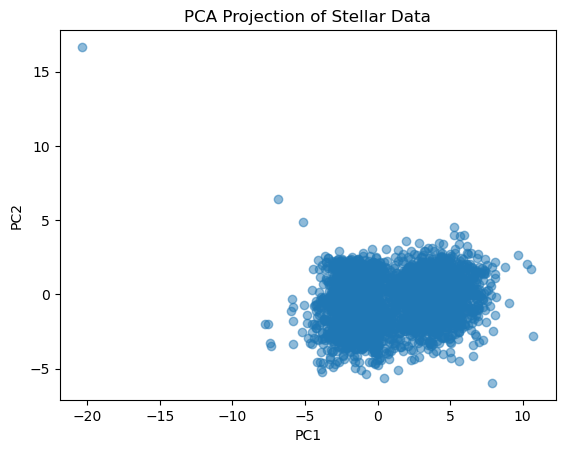

In [43]:
pca = PCA(n_components = 2)                 # 2D projection for visualization
X_pca = pca.fit_transform(X_scaled)         # PCA transformation - i.e., projection

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha = 0.5)          
plt.title('PCA Projection of Stellar Data')         
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Intersection point: x = 11, y = 0.9124262371735187


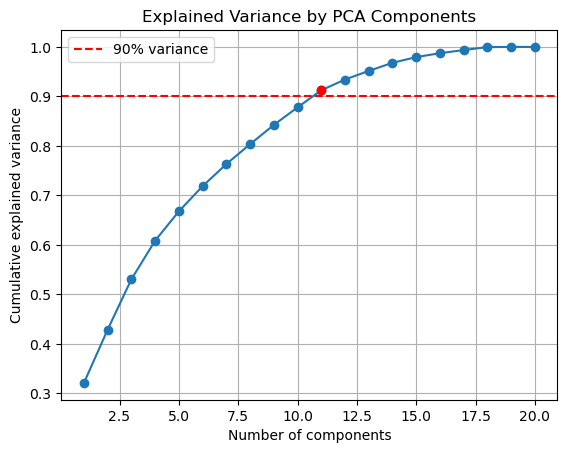

In [44]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)

# Finding intersection point
def find_intersection(x, y):
    # Find the index of the first point where y is greater than or equal to 0.9
    index = np.where(y >= 0.9)[0][0]
    return x[index], y[index]

# Find the intersection point
intersection_x, intersection_y = find_intersection(range(1, len(explained_var)+1), explained_var)
print(f"Intersection point: x = {intersection_x}, y = {intersection_y}")

plt.plot(range(1, len(explained_var)+1), explained_var, marker = 'o')
plt.scatter(intersection_x, intersection_y, color = 'red', zorder = 5)
plt.axhline(0.9, color = 'red', linestyle = '--', label = '90% variance')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.legend()
plt.grid()
plt.show()

We need $\sim 12$ parameters to explain 90% of the variance. This suggests that the data has moderate intrinsic dimensionality – it’s not extremely redundant, but there is enough structure to support clustering. This gives a solid justification to reduce to 12 dimensions using PCA before clustering. It both: 
- Reduces noise and redundant features
- Speeds up computations and helps clustering algorithms



In [45]:
pca = PCA(n_components = 12)
X_reduced = pca.fit_transform(X_scaled)

### Trying clustering - K-means 

In [46]:
results = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(X_reduced)
    
    sil = silhouette_score(X_reduced, labels)
    ch = calinski_harabasz_score(X_reduced, labels)
    db = davies_bouldin_score(X_reduced, labels)
    
    results.append((k, sil, ch, db))

# Show results as a table
import pandas as pd

df_metrics = pd.DataFrame(results, columns=["k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(df_metrics.sort_values("Silhouette", ascending = False))

    k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2    0.386234        2273.327719        1.335287
1   3    0.364547        1341.784542        2.071972
2   4    0.186702        1195.635530        2.232960
3   5    0.184787         984.531626        2.125813
5   7    0.165785         819.624574        2.015605
4   6    0.163909         927.186532        2.032337
7   9    0.147776         814.421848        1.827433
6   8    0.138317         872.600485        1.827876
8  10    0.135401         757.588247        1.852615


Based on these metrics, it seems like the optimal cluster count is 2 (<i>Silhouette</i>: best value is high, <i>Calinski-Harabasz</i>: best value is high, <i>Davies-Bouldin</i>: best value is low). It seems like $\texttt{k = 2}$ yields best scores across all metrics, while $\texttt{k = 3}$ is still reasonable.  

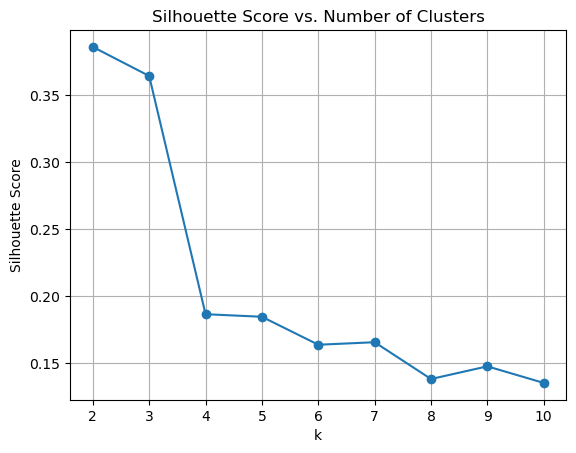

In [47]:
plt.plot(df_metrics['k'], df_metrics['Silhouette'], marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

Based on the sharp drop in silhouette scores after $\texttt{k = 3}$ suggests that we're forcing more clusters than the structure supports. At higher $\texttt{k}$, clusters <b>overlap</b> and become less compact and less separated. 
<br><br>
So, based on this it seems like the data likely has 2-3 natural groupings (could be disk vs. halo stars, young vs. old stars, chemically enriched va. metal-poor populations). Take into account, this is only <i>statistical groupings</i>. 

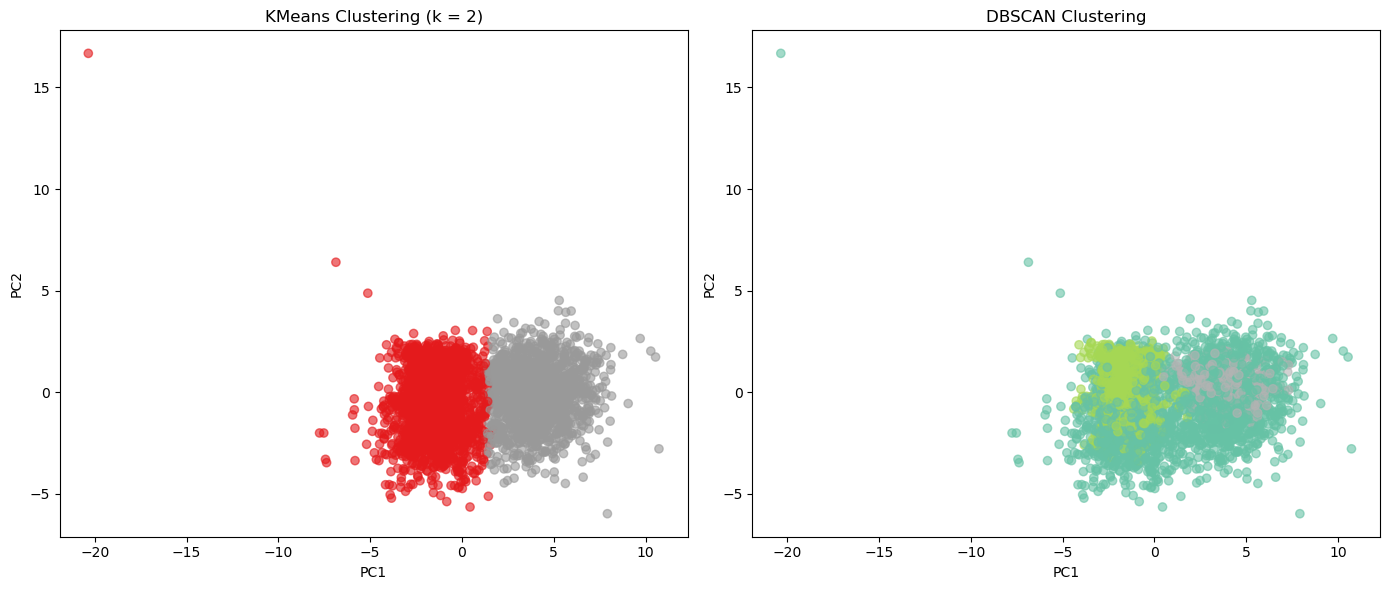

In [54]:
# Final K-Means clustering with the best k

# PCA to 2 components for plotting
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

# KMeans clustering (k = 2)
kmeans = KMeans(n_clusters = 2, random_state = 42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# DBSCAN clustering for comparison
dbscan = DBSCAN(eps = 2, min_samples = 10)  # You can tune these!
labels_dbscan = dbscan.fit_predict(X_scaled)

# Step 5: Plot results
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

# KMeans plot
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c = labels_kmeans, cmap = 'Set1', alpha = 0.6)
ax[0].set_title("KMeans Clustering (k = 2)")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# DBSCAN plot
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c = labels_dbscan, cmap = 'Set2', alpha = 0.6)
ax[1].set_title("DBSCAN Clustering")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

### Solving the exercise
Cluster particle signatures into 5-50 catagories in dataset 2. This should be based on maximum 7 variables from the Variable List 2. In this case, there is no target variable, as this is unsupervised learning. Your solution should simply be the number of the category, that you assign the event to belong to, i.e. an integer [0, 1, ..., n] for n+1 categories (n in [5,50]).

Energy        3.900940e+09
Lz            1.085920e+07
Unnamed: 0    2.950704e+06
J             1.250752e+00
H             1.165388e+00
K             1.155551e+00
V_FE          1.128677e-01
NA_FE         1.127459e-01
FE_H          9.134656e-02
S_FE          7.731425e-02
dtype: float64


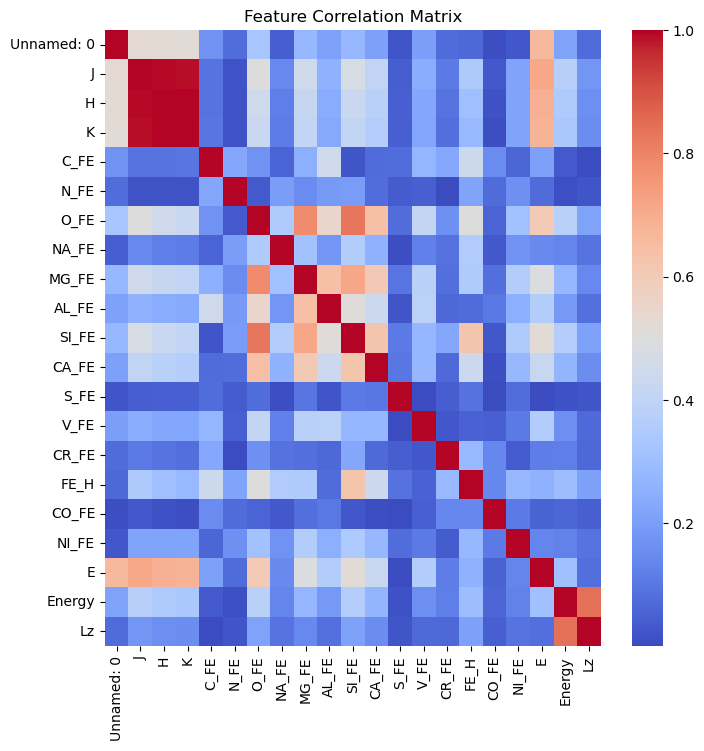

Dropped features: {'H', 'SI_FE', 'Lz', 'K'}
Remaining features: ['J', 'C_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'CA_FE', 'S_FE', 'V_FE', 'CR_FE', 'FE_H', 'CO_FE', 'NI_FE', 'E', 'Energy']
Shape of the cleaned data: (5950, 16)


In [57]:
# Choosing features for clustering
variances = df.var().sort_values(ascending = False)
print(variances.head(10))

# Removing highly correlated features
corr_matrix = df.corr().abs()

plt.figure(figsize = (8, 8))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = False)
plt.title("Feature Correlation Matrix")
plt.show()

# Excluding features with high correlation - i.e., > 0.8-0.9
threshold = 0.8
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# Drop the features
df_clean = df_clean.drop(columns = to_drop)

# Check the shape of the cleaned data and priting which features were dropped and which are left
print("Dropped features:", to_drop)
print("Remaining features:", df_clean.columns.tolist())
print("Shape of the cleaned data:", df_clean.shape)

In [58]:
import itertools
import random

"""Testing random combinations of 7 features for clustering."""

# SETTINGS
k = 10                                          # Number of clusters to evaluate
n_combinations = 200                            # Number of random 7-feature combinations

# Prepare list of remaining features
remaining_features = df_clean.columns.tolist()

# Generate random combinations of 7 features
random.seed(42)
feature_combos = random.sample(list(itertools.combinations(remaining_features, 7)), n_combinations)

# Store results
results = []

for combo in tqdm(feature_combos, desc="Evaluating 7-feature combinations"):
    X = df_clean[list(combo)]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Optional: PCA to reduce to 5D for improved clustering geometry
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    # Silhouette score
    try:
        sil_score = silhouette_score(X_pca, labels)
    except:
        sil_score = -1  # fallback if clustering fails

    results.append({
        "features": combo,
        "silhouette": sil_score
    })

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="silhouette", ascending=False)

# Show top 5 results
print("\nTop 5 feature combinations by silhouette score:")
print(results_df_sorted.head())

Evaluating 7-feature combinations:   0%|          | 0/200 [00:00<?, ?it/s]


Top 5 feature combinations by silhouette score:
                                             features  silhouette
55   (O_FE, MG_FE, AL_FE, CR_FE, FE_H, CO_FE, Energy)    0.273862
99             (J, C_FE, N_FE, AL_FE, CA_FE, FE_H, E)    0.264254
133   (O_FE, MG_FE, AL_FE, V_FE, CR_FE, FE_H, Energy)    0.264202
142  (C_FE, MG_FE, AL_FE, FE_H, CO_FE, NI_FE, Energy)    0.263801
4        (J, O_FE, CA_FE, CR_FE, FE_H, CO_FE, Energy)    0.263043


In [61]:
# Choosing the top-performing feature combination
best_combo = results_df_sorted.iloc[0]['features']
print("Best feature combination:", best_combo, 'with a silhouette score of', results_df_sorted.iloc[0]['silhouette'])

final_features = ['O_FE', 'MG_FE', 'AL_FE', 'CR_FE', 'FE_H', 'CO_FE', 'Energy']

# Subset and scale
X_final = df_clean[final_features]
X_scaled = StandardScaler().fit_transform(X_final)
X_pca = PCA(n_components = 5).fit_transform(X_scaled)

results = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    results.append((k, sil, ch, db))


df_metrics = pd.DataFrame(results, columns=["k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(df_metrics.sort_values("Silhouette", ascending = False))

Best feature combination: ('O_FE', 'MG_FE', 'AL_FE', 'CR_FE', 'FE_H', 'CO_FE', 'Energy') with a silhouette score of 0.273862156528624
    k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2    0.392502        2198.526319        1.302423
3   5    0.265198        1457.510132        1.267889
2   4    0.255948        1599.594204        1.377560
5   7    0.249293        1521.099186        1.170451
4   6    0.247553        1336.469254        1.360179
1   3    0.241254        1832.650139        1.304833
6   8    0.240292        1438.429850        1.166530
8  10    0.215190        1284.678643        1.345306
7   9    0.214016        1331.880596        1.222739


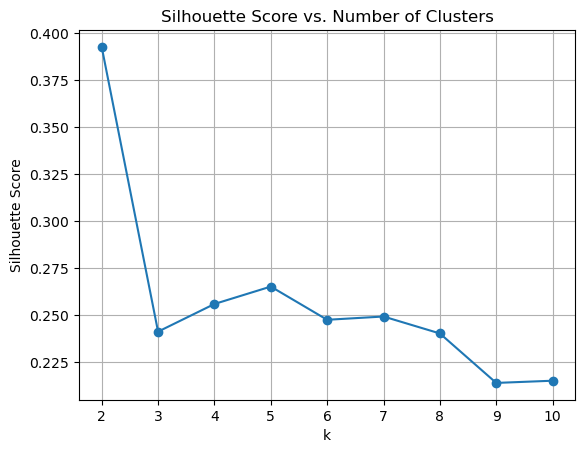

In [62]:
plt.plot(df_metrics['k'], df_metrics['Silhouette'], marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

Based on the assignment and the plot above it seems like $\texttt{k = 5}$ is the best tradeoff with the highest silhouette of all $\texttt{k}-values$ over 5. 

Text(0, 0.5, 'PC2')

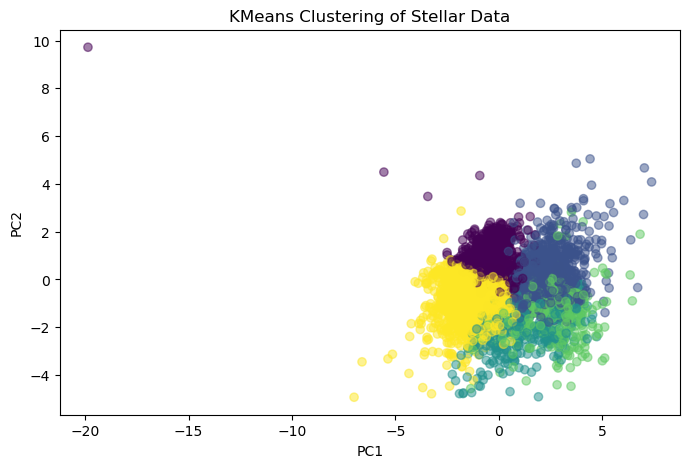

In [64]:
X_pca = PCA(n_components = 5).fit_transform(X_scaled)
kmeans_final = KMeans(n_clusters = 5, random_state = 42)
labels_final = kmeans_final.fit_predict(X_pca)

df_clean['cluster_id'] = labels_final

# Plotting the clusters
plt.figure(figsize = (8, 5))

# Create a scatter plot of the PCA-reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels_final, cmap = 'viridis', alpha = 0.5)
plt.title("KMeans Clustering of Stellar Data")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [74]:
# Saving a txt file with the features used 
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AppliedML2025/Initial project/Initial Project Solutions/Clustering'

# Best variables
outfile = open(path + '/Clustering_ChamillaTerp_KMeans_VariableList.txt', 'w')

for var in final_features:
    outfile.write(var+'\n')

outfile.close()

# Saving the category numbers for each star
cluster_numbers = df_clean['cluster_id'].values

print(cluster_numbers.shape)

cluster_numbers = pd.DataFrame(cluster_numbers, columns = ['cluster_id'])
cluster_numbers.to_csv(path + '/Clustering_ChamillaTerp_KMeans.txt', index = True, header = None, mode = 'w')

(5950,)


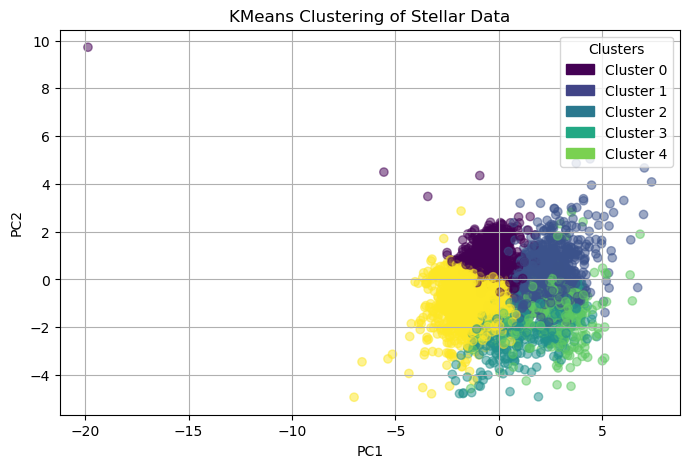

In [75]:
# Plotting the final clusters
plt.figure(figsize = (8, 5))

# Create a scatter plot of the PCA-reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels_final, cmap = 'viridis', alpha = 0.5)
plt.title("KMeans Clustering of Stellar Data")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Create a legend
handles = []
for i in range(5):
    handles.append(patches.Patch(color=plt.cm.viridis(i/5), label=f'Cluster {i}'))

plt.legend(handles=handles, title="Clusters", loc='upper right')
plt.grid()
plt.show()